In [1]:
from timesteppers import IMEXEuler
from RDModels import GrayScott, HeatEquation
import numpy as np
import numpy.typing as npt
from scipy.sparse.linalg import spsolve
from typing import Optional


Below the heat equation is solved using IMEX Euler

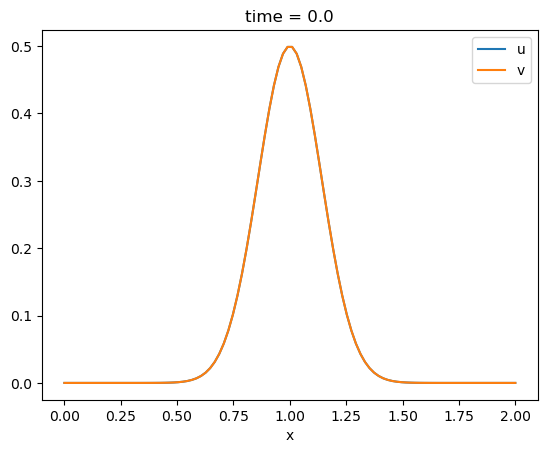

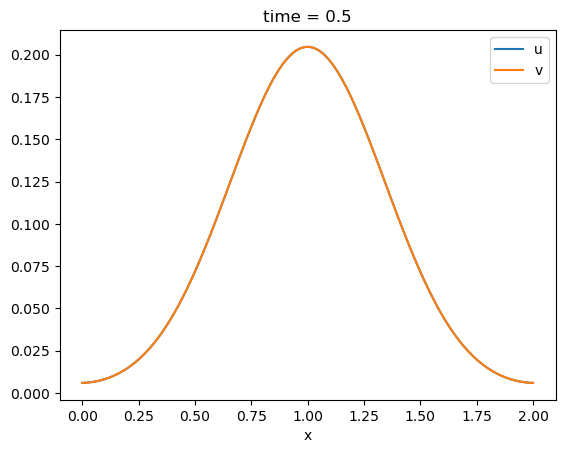

In [2]:
# discretization parameters
L: int = 2
Nx: int = 100
Nt: int = 100
discretization: npt.NDArray = np.array([Nx], dtype=int)
tmin: float = 0.0 
tmax: float = 0.5

# Model parameters
Du: float = 1e-1
Dv: float = 1e-1

# Initial condition
x: npt.NDArray = np.linspace(0, L, Nx)
perturb: npt.NDArray = np.exp(-25*np.power(x-1, 2))*0.5
upart: npt.NDArray = np.copy(perturb)
vpart: npt.NDArray = np.copy(perturb)
u0: npt.NDArray = np.hstack((upart, vpart))

# Make PDE object
h1: HeatEquation = HeatEquation(discretization, L, Du, Dv)

# Make time stepper
imex1: IMEXEuler = IMEXEuler(h1)

# Integrate
imex1.integrate(tmin, tmax, Nt, u0)
res: Optional[npt.NDArray] = imex1.res

# Plot
h1.plot(imex1.time, 0, imex1.res)
h1.plot(imex1.time, np.shape(imex1.time)[0]-1, imex1.res)



Code equation solution to heat equation on periodic domain.

In [3]:

def exactHeatSol(x: npt.NDArray, t: float, Acoeff, Bcoeff, D) -> npt.NDArray:
    s = len(Acoeff)
    res: npt.NDArray = np.zeros_like(x)
    for i in range(s):
        texp = np.exp(-D*t*np.power(i*np.pi/L, 2))
        res += Acoeff[i]*np.cos(i*np.pi*x/L)*texp + Bcoeff[i]*np.sin(i*np.pi*x/L)*texp
    return res

Compute exact solution at t = 0.5. Compute error of IMEX Euler

In [4]:
from scipy.integrate import quad

Nterms: int = 70
initf = lambda x: -np.cos(2*np.pi*x/(2*L))  # cosine with periode L
Afunc = lambda x, n : initf(x)*np.cos(n*np.pi*x/L)
Bfunc = lambda x, n : initf(x)*np.sin(n*np.pi*x/L)

Acoeff: npt.NDArray = np.zeros((Nterms, ))
Bcoeff: npt.NDArray = np.zeros_like(Acoeff)

i1, _ = quad(initf, -L, L)
Acoeff[0] = i1/(2*L)
for i in range(1, Nterms):
    i1, _ = quad(Afunc, -L, L, args=(i, ))
    i2, _ = quad(Bfunc, -L, L, args=(i, ))
    Acoeff[i] = i1/L
    Bcoeff[i] = i2/L

In [11]:
from numpy import zeros_like
import matplotlib.pyplot as plt

mu = 1.1
Nxs: npt.NDArray = np.logspace(1.5, 3, 20, dtype=int)
dxs: npt.NDArray = (2*L)/(Nxs+1)
dts: npt.NDArray = mu*np.power(dxs, 2)/(2*Dv)
Nts: npt.NDArray = (((tmax - tmin)/dts) + 1).astype(int)


# Compute errors
err: npt.NDArray = zeros_like(Nts, dtype=np.float64)
for index, Nt in enumerate(Nts):
    Nx: int = Nxs[index] 

    # Exact solution
    exactSol: npt.NDArray = exactHeatSol(np.linspace(-L, L, Nx), tmax, Acoeff, Bcoeff, Dv)

    # Make PDE object
    discretization: npt.NDArray = np.array([Nx])
    h1: HeatEquation = HeatEquation(discretization, 2*L, Du, Dv)

    # Make time stepper
    imex1: IMEXEuler = IMEXEuler(h1)

    # Initial condition
    xs = np.linspace(0, 2*L, Nx)
    x0part: npt.NDArray = np.cos(2*np.pi*xs/(2*L))
    x0 = np.hstack((x0part, x0part))

    # Integrate
    imex1.integrate(tmin, tmax, Nt, x0)
    vmax: npt.NDArray = imex1.res[-1, Nx:]
    err[index] = np.absolute(vmax - exactSol).max() # type: ignore
    # err[index] = np.linalg.norm(vmax - exactSol) # type: ignore


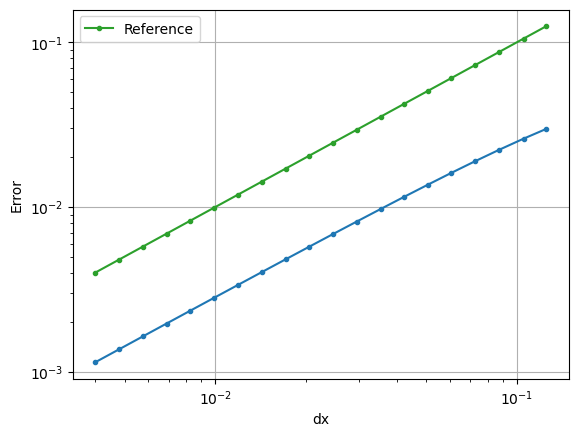

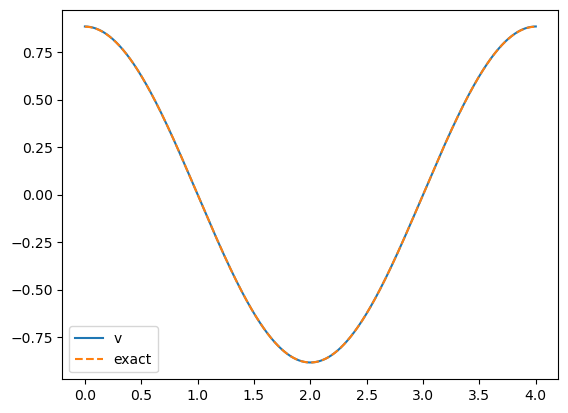

In [13]:
plt.figure(1)
plt.loglog(dxs, err, '--', 'Measurement')
plt.loglog(dxs, dxs, '.-', label='Reference')
plt.xlabel('dx')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.show()


plt.figure(2)
plt.plot(xs, vmax, label='v')
plt.plot(xs, exactSol, '--', label='exact')
plt.legend()
plt.show()

In [7]:
Bcoeff

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])